### WORD2VEC TUTORIAL




* NLP converts words/text/language into a number of some kind. Pre 2013 most nlp models were word count based models. Word2vec changed everything.  


* We will train a word2vec model and then skip to one of the more recent models released by Facebook called Roberta. The models have changed significantly between the release of word2vec(2013) and Roberta(2018). 


* Word2vec is a word association model and is designed to produce similar weights to words that occur together in actual text. The model's weights are referred to as word embeddings. The inference is that the word embeddings or weights from the model will numerically capture or reflect words that are contextually similar.    




### Objectives of notebook

1. Introduce the word2vec model and focus on the CBOW version of word2vec. 
2. Illustrate the model with an example to check if the model selects similar words.
3. Visualise the model in two dimensional space


### Summary of models used in this notebook
1. Word2vec(CBOW): https://radimrehurek.com/gensim/models/word2vec.html
2. PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
3. TSNE: https://scikit-learn.org/0.15/modules/generated/sklearn.manifold.TSNE.html



#### Footnote/references:


Research paper Word2vec: https://arxiv.org/abs/1301.3781

Link to personal nlp work: https://github.com/bfopengradient/NLP_classify_conduct_risk_related_communications

Citation: tsne scatterplot code copied from 'https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial'



## Install gensim to access the word2vec model

 

In [1]:
#Import the following 
import pandas as pd 
import numpy as np
from gensim.models import Word2Vec
from sklearn import decomposition
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Read in cleaned csv for word2vec. Cleaning/preprossing was light !

In [2]:
#Assign csv to dataframe
df_clean= pd.read_csv('./word2vec.csv').drop(columns=('Unnamed: 0'))  
#Check top of dataframe
df_clean.head()

,clean
0,jurong point crazy available bugis n great wor...
1,ok lar joke wif u oni
2,free entry wkly comp win fa cup final tkts st ...
3,u dun early hor u c
4,nah think go usf live


### Create sentences(list of strings) for  word2vec.

In [3]:
#Produce a list of strings for each sentence for word2vec
sent = [row.split() for row in df_clean['clean']]

### Define word2vec model

Two choices in terms of how you wish to train the word2vec model.

CBOW is trained to predict a single word from a fixed window size of context words, whereas Skip-gram does the opposite, and tries to predict several context words from a single input word.



In [4]:
#Define model parameters
w2v_model = Word2Vec(min_count=20,      #Ignores all words with total frequency lower than this.
                     window=2,          #Maximum distance between the current and predicted word within a sentence.
                     size=300,          #Dimensionality of the word vectors.
                     sg=0,              #Training algorithm: 1 for skip-gram; otherwise CBOW.
                     sample=6e-5,       #The threshold for configuring which higher-frequency words are randomly downsampled,useful range is (0, 1e-5)
                     alpha=0.03,        #The initial learning rate.
                     min_alpha=0.0007,  #Learning rate will linearly drop to `min_alpha` as training progresses.
                     negative=20,       #sample size of "noise words" for use in negative sampling
                     batch_words=5,     #set batch size for frequency of weight updates during training
                     iter=5)            #number of epochs to train the model

### Build model vocabulary 

In [5]:
#Build model vocabulary 
w2v_model.build_vocab(sent)

#Assign vocabulary to a variable
vocabulary= w2v_model.wv.index2word 

### Train the word2vec model and check output

In [6]:
#Train the model on the sentences and test against word similarity

#Train model
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30)

#Check cosine similarity to a word vector in the vocabulary
w2v_model.wv.most_similar(positive=["win"]) 

[('draw', 0.9999180436134338),
 ('contact', 0.999915599822998),
 ('urgent', 0.9999099373817444),
 ('claim', 0.9999089241027832),
 ('attempt', 0.9999068379402161),
 ('land', 0.9999048709869385),
 ('award', 0.9999042749404907),
 ('guarantee', 0.9999029040336609),
 ('w', 0.9999027252197266),
 ('collect', 0.9999023675918579)]

### Visualise the word vectors and test model with ten random words/tokens from the vocabulary.

In [7]:
#Pick ten random words from the vocabulary
random_tokens = np.random.choice(list(w2v_model.wv.index2word),10)
random_tokens

array(['end', 'online', 'com', 'game', 'ah', 'word', 'order', 'nite',
       'reach', 'baby'], dtype='<U9')

### Two dimensionality algorithms used to reduce dimenions from 300 to just 2. PCA and TSNE.

In [8]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of random words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # Adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # Gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # Adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    #Adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    #Changed hyperparameters to highlight clusters.
    #Perplexity set to 15. “perplexity,” which says (loosely) how to 
    #balance attention between local and global aspects of your data. See article cite below regarding perplexity.
    # https://distill.pub/2016/misread-tsne/
    Y = TSNE(n_components=2, random_state=0,n_iter=5000, learning_rate=1000,perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    
    
# tsnescatterplot code copied from 'https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial'    

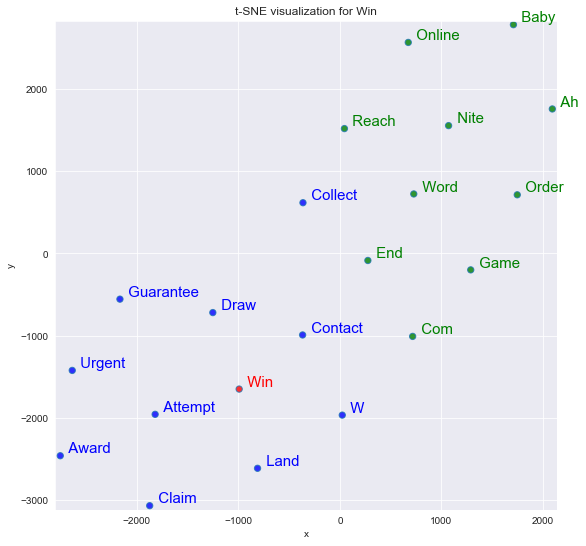

In [9]:
#Call the plot function.. Selected word is  'win'
tsnescatterplot(w2v_model, 'win', random_tokens)

#The selected word is red
#Random words are green
#Ten most similar words according to the model are blue.